In [29]:
%matplotlib inline

# Excercise 1 - Implementing k-nearest neighbors

Load data sets

In [1]:
import numpy as np
X_train = np.genfromtxt('MNIST_X_train.csv', delimiter=',')
y_train = np.genfromtxt('MNIST_y_train.csv', delimiter=',')

X_test = np.genfromtxt('MNIST_X_test.csv', delimiter=',')
y_test = np.genfromtxt('MNIST_y_test.csv', delimiter=',')

Even with recyclying dist computation and breaking it up into a fold at a time, it still takes too much time and memory on my machine. Limiting the data set using train_size and taking a random sample of rows.

In [12]:
train_size = int(0.5*X_train.shape[0])
idx = np.random.choice(np.arange(len(X_train)), train_size, replace=False)
X_train = X_train[idx]
y_train = y_train[idx]

### K-Nearest Neighbours classifier 
All operations using only matrix computations. Uses argpartition to select k_smallest for each set in O(n) time. It accomplishes this by arbitrarily guessing a pivot value for k and makes n comparisons to place elements smaller than pivot to left, and larger to the right. If k < arg(pivot) - recurse on left, if k > arg(pivot) - recurse on right, if k == arg(pivot) we have our partition. Since we only recurse on one side we can achieve on average O(n) complexity. In worst case this can be O(n^2) so if the size of the partitions is not decreasing at a fast enough rate the algorithm uses mean-of-means to pick a suitable pivot value in O(n), so overall worst case becomes O(n). 

In [13]:
from scipy.stats import mode
from scipy.spatial import distance
def KNearestNeighbourClassifier(x_train, y_train, z_test, k, dists=None):
    if (dists is None):
        dists = distance.cdist(z_test, x_train, 'euclidean')
    k_smallest = y_train[np.argpartition(dists, k, axis=1)][:,:k] # take k smallest labels from partitioning each dists along row 
    pred = mode(k_smallest, axis=1)[0].flatten()
    return pred, dists # recycle dists computation

### Compute the error rates for k = [1, 5, 10 ... 50] using 10 fold cross-validation
Cross validation is outer loop to cleanly recycle the distances and compute all cv for certain k at once.

In [14]:
from sklearn.model_selection import KFold
n_folds = 10
min_k = 1
max_k = 50
step = 5
cv_kfold = KFold(n_folds)
cv_avg_scores = np.zeros(10)
for train_idx, validation_idx in cv_kfold.split(X_train):
    dists = None
    for k in range(min_k, max_k+1, step):
        # avoid recomputing dists
        pred, dists = KNearestNeighbourClassifier(X_train[train_idx], y_train[train_idx], X_train[validation_idx], k, dists)
        cv_avg_scores[k//step] += np.count_nonzero(np.equal(pred, y_train[validation_idx]))/len(y_train)

### Plot error rates

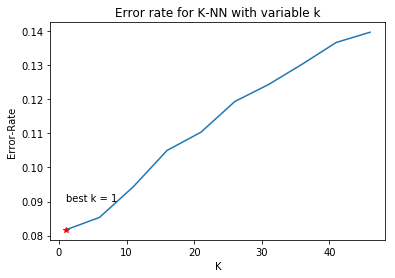

In [40]:
error_rates = 1 - cv_avg_scores
k_range = np.arange(min_k, max_k, step)
min_idx = np.argmin(error_rates)
import matplotlib.pyplot as plt
plt.plot(k_range,error_rates)
plt.plot(k_range[min_idx], error_rates[min_idx], 'r*')
plt.text(k_range[min_idx], 0.09, r'best k = {}'.format(k_range[min_idx]))
plt.xlabel('K')
plt.ylabel('Error-Rate')
plt.title('Error rate for K-NN with variable k')
plt.show()

### Validating scores make sense using sklearn

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
k_range = [1, 5, 11, 21, 31, 41, 51]
means = np.zeros([len(k_range)])
for idx, k in enumerate(k_range):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train)
    means[idx] = np.mean(scores)

In [41]:

k_range = [1, 5, 11, 21, 31, 41, 51]

In [42]:
for i, idx in enumerate(k_range):
    print(i, idx)

0 1
1 5
2 11
3 21
4 31
5 41
6 51


In [47]:
means

array([ 0.91135902,  0.90536964,  0.89303216,  0.87372793,  0.85805976,
        0.84204358,  0.82438069])